In [99]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import numpy as np

init_data = load_breast_cancer()
(X, y) = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(data=X, columns=init_data['feature_names'])
y = pd.DataFrame(data=y, columns=['label'])

# split X into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.3, random_state=0)

In [100]:
from sklearn.preprocessing import StandardScaler

# Z-normalize data
sc = StandardScaler()
Z = sc.fit_transform(X)
# Estimate the correlation matrix
R = np.dot(Z.T, Z) / y.shape[0]

eigen_vals, eigen_vecs = np.linalg.eigh(R)

print('\nEigenvalues: \n%s' % eigen_vals)


Eigenvalues: 
[  1.33044823e-04   7.48803097e-04   1.58933787e-03   6.90046388e-03
   8.17763986e-03   1.54812714e-02   1.80550070e-02   2.43408378e-02
   2.74394025e-02   2.99728939e-02   3.11594025e-02   4.94775918e-02
   5.26187835e-02   5.93990378e-02   7.98628010e-02   9.41349650e-02
   1.57009724e-01   2.41357496e-01   2.61161370e-01   2.93915696e-01
   3.50693457e-01   4.16894812e-01   4.76617140e-01   6.75220114e-01
   1.20735661e+00   1.64873055e+00   1.98064047e+00   2.81794898e+00
   5.69135461e+00   1.32816077e+01]


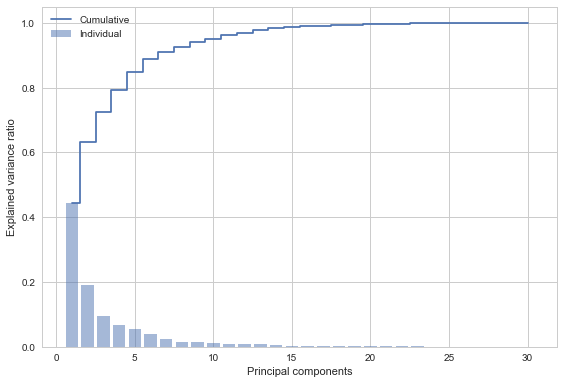

In [101]:
import matplotlib.pyplot as plt

tot = sum(np.abs(eigen_vals))
var_exp = [(i / tot) for i in sorted(np.abs(eigen_vals), reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, eigen_vals.size + 1), var_exp, alpha=0.5, align='center',
        label='Individual')
plt.step(range(1, eigen_vals.size + 1), cum_var_exp, where='mid',
         label='Cumulative')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('./output/lab04-fig-pca-var-exp.png', dpi=300)
plt.show()

In [102]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(reverse=True)

#form the projection matrix
W = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))

print('Projection matrix W:\n', W)

Projection matrix W:
 [[-0.21890244  0.23385713]
 [-0.10372458  0.05970609]
 [-0.22753729  0.21518136]
 [-0.22099499  0.23107671]
 [-0.14258969 -0.18611302]
 [-0.23928535 -0.15189161]
 [-0.25840048 -0.06016536]
 [-0.26085376  0.0347675 ]
 [-0.13816696 -0.19034877]
 [-0.06436335 -0.36657547]
 [-0.20597878  0.10555215]
 [-0.01742803 -0.08997968]
 [-0.21132592  0.08945723]
 [-0.20286964  0.15229263]
 [-0.01453145 -0.20443045]
 [-0.17039345 -0.2327159 ]
 [-0.15358979 -0.19720728]
 [-0.1834174  -0.13032156]
 [-0.04249842 -0.183848  ]
 [-0.10256832 -0.28009203]
 [-0.22799663  0.21986638]
 [-0.10446933  0.0454673 ]
 [-0.23663968  0.19987843]
 [-0.22487053  0.21935186]
 [-0.12795256 -0.17230435]
 [-0.21009588 -0.14359317]
 [-0.22876753 -0.09796411]
 [-0.25088597  0.00825724]
 [-0.12290456 -0.14188335]
 [-0.13178394 -0.27533947]]


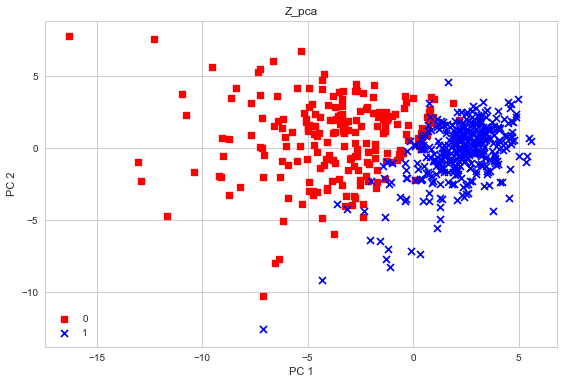

In [103]:
Z_pca = Z.dot(W)

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y.values.ravel()), colors, markers):
    plt.scatter(Z_pca[y.values.ravel()==l, 0], 
                Z_pca[y.values.ravel()==l, 1], 
                c=c, label=l, marker=m)

plt.title('Z_pca')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig('./output/lab04-fig-pca-z.png', dpi=300)
plt.show()

In [104]:
# Split training and testing data (test_size = 30% of the whole dataset)
Z_pca_train, Z_pca_test, y_pca_train, y_pca_test = train_test_split(
    Z_pca, y.values.ravel(), test_size=0.3, random_state=0)

# Modified by MosQuito
print('#Training data points: %d' % Z_pca_train.shape[0])
print('#Testing data points: %d' % Z_pca_test.shape[0])
# End of modified

#Training data points: 398
#Testing data points: 171


In [105]:
class AdalineGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    random_state : int
        The seed of the pseudo random number generator.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.activation(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

In [109]:
from numpy.random import seed

class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(xi)
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, 0)

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

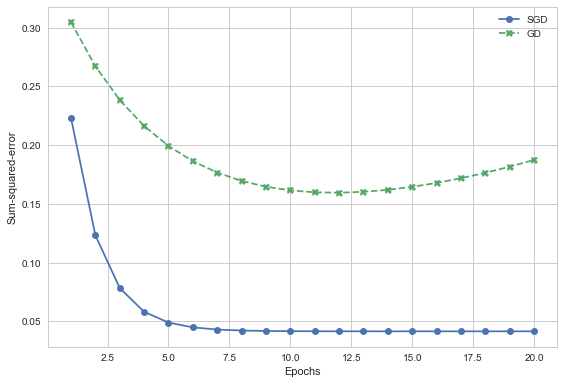

AdalineGD:
Misclassified samples: 68
Accuracy: 0.60
-----
AdalineSGD:
Misclassified samples: 53
Accuracy: 0.69


In [128]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

sc = StandardScaler()
sc.fit(Z_pca_train)
Z_pca_train_std = sc.transform(Z_pca_train)
Z_pca_test_std = sc.transform(Z_pca_test)

#eta=0.0048
ada = AdalineGD(n_iter=20, eta=0.0048)
ada.fit(Z_pca_train_std, y_pca_train)

#eta=0.001
adas = AdalineSGD(n_iter=20, eta=0.001, random_state=1)
adas.fit(Z_pca_train_std, y_pca_train)

plt.plot(range(1, len(adas.cost_) + 1), adas.cost_, 
         marker='o', label='SGD')
plt.plot(range(1, len(ada.cost_) + 1), np.array(ada.cost_) / len(y_pca_train), 
         marker='X', linestyle='--', label='GD')

plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('./output/Lab04-1_105062620.png', dpi=300)
plt.show()

# testing accuracy
y_pca_pred1 = ada.predict(Z_pca_test_std)
print('AdalineGD:')
print('Misclassified samples: %d' % (y_pca_test != y_pca_pred1).sum())
print('Accuracy: %.2f' % accuracy_score(y_pca_test, y_pca_pred1))

print('-----')
print('AdalineSGD:')
y_pca_pred2 = adas.predict(Z_pca_test_std)
print('Misclassified samples: %d' % (y_pca_test != y_pca_pred2).sum())
print('Accuracy: %.2f' % accuracy_score(y_pca_test, y_pca_pred2))